# Data augmentation
> This notebook is for
>
> Testing imgaug python library
> 
> And some image augmentation methods that I'll use in my training pipeline

### Refs
1. https://neptune.ai/blog/what-image-processing-techniques-are-actually-used-in-the-ml-industry
2. https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets
3. https://github.com/aleju/imgaug

## Methods
1. Horizontal flip
2. Random resize/crop/zoom
3. Elastic distortion
4. Rotation
5. Some color techniques
6. Gaussian noise
7. A patching method

In [1]:
import sys
sys.path.append('../src/scripts')


In [2]:
from dataset import extract_boxes

def load_mask(annotation_path): 

	boxes, w, h = extract_boxes(annotation_path)

	masks = np.zeros([h, w, len(boxes)], dtype=np.uint8)
	for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
		masks[ymin:ymax, xmin:xmax, i] = 1
	
	return masks

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_image(image,fig_size=(3,3), boxes=[], masks=[], title='Original Image'):
	plt.figure(figsize=fig_size)
	plt.imshow(image)

	ax = plt.gca()
	for box in boxes:
		xmin, ymin, xmax, ymax = box
		width, height = xmax - xmin, ymax - ymin
		
		rectangle = Rectangle((xmin, ymin), width, height, fill=False, color = 'red')
		ax.add_patch(rectangle)

	for mask_idx in range(masks.shape[2]):
		plt.imshow(masks[:,:, mask_idx], cmap='gray', alpha=0.2)

	plt.title(title)
	plt.show()

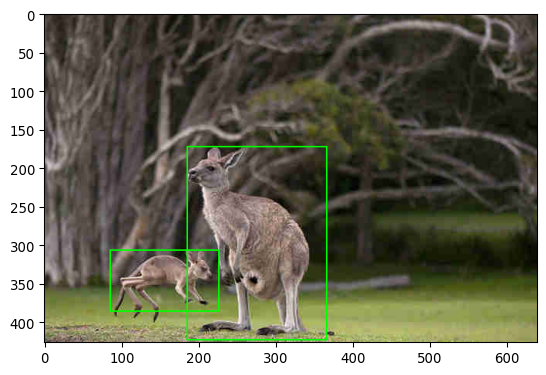

In [4]:
import numpy as np
import imageio.v3 as imageio
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

img_filename = '../data/kangaroo/images/00006.jpg'
image = imageio.imread(img_filename)
annotation_path = img_filename.replace('images', 'annots').replace('jpg', 'xml')
mask = load_mask(annotation_path)
boxes, _, _ = extract_boxes(annotation_path)
boxes = BoundingBoxesOnImage([
	BoundingBox(*box) for box in boxes
], shape=image.shape)

ia.imshow(boxes.draw_on_image(image, size=2))


In [6]:
import imgaug.augmenters as iaa

# ia.seed(0)
seq = iaa.Sequential([
	# 1. Flip
	iaa.Fliplr(0.5), # flip left/right with 0.5 probability
	# 2. Affine
	iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
							rotate=(-30, 30),
							scale=(0.5, 1.5)),

	# Perform methods below only sometimes
	iaa.Sometimes(0.5,
			# 5. GaussianBlur
			iaa.GaussianBlur((0.0, 3.0))
			)
], random_order= True)

In [10]:
'''
	NOTE: The location of aug.to_deterministic is important !!!
 	1. the augmenter returned by to_deterministic() is never changing
		-> and apply same effect to all of it's inputs
	2. So the difference comes at "WHEN" we convert it to deterministic
		a) If we convert it from the start of the training set -> means all inputs have same applied affect
		b) If we convert it only when we're iterating image by image -> means each image have different apply effect
			But the image and it's mask have same applied effect (important for MaskRCNN training)
	3. That's why the <! important line> is in this cell and not the above one
		-> to make sure the sequence augmenter is deterministic "per sample image"
		-> not "per batch" or "per epoch" or "per dataset" !!
'''


def get_image(image, mask):
	augmenter = seq.to_deterministic() # ! important line
	image_aug = augmenter.augment_image(image)
	# Change mask to np.uint8 because imgaug doesn't support np.bool
	mask_aug = augmenter.augment_image(mask.astype(np.uint8))

	return image_aug, mask_aug

n_rows, n_cols = 5, 2
augmentations = [get_image(image, mask) for _ in range(n_rows * n_cols)]

(10, 15)


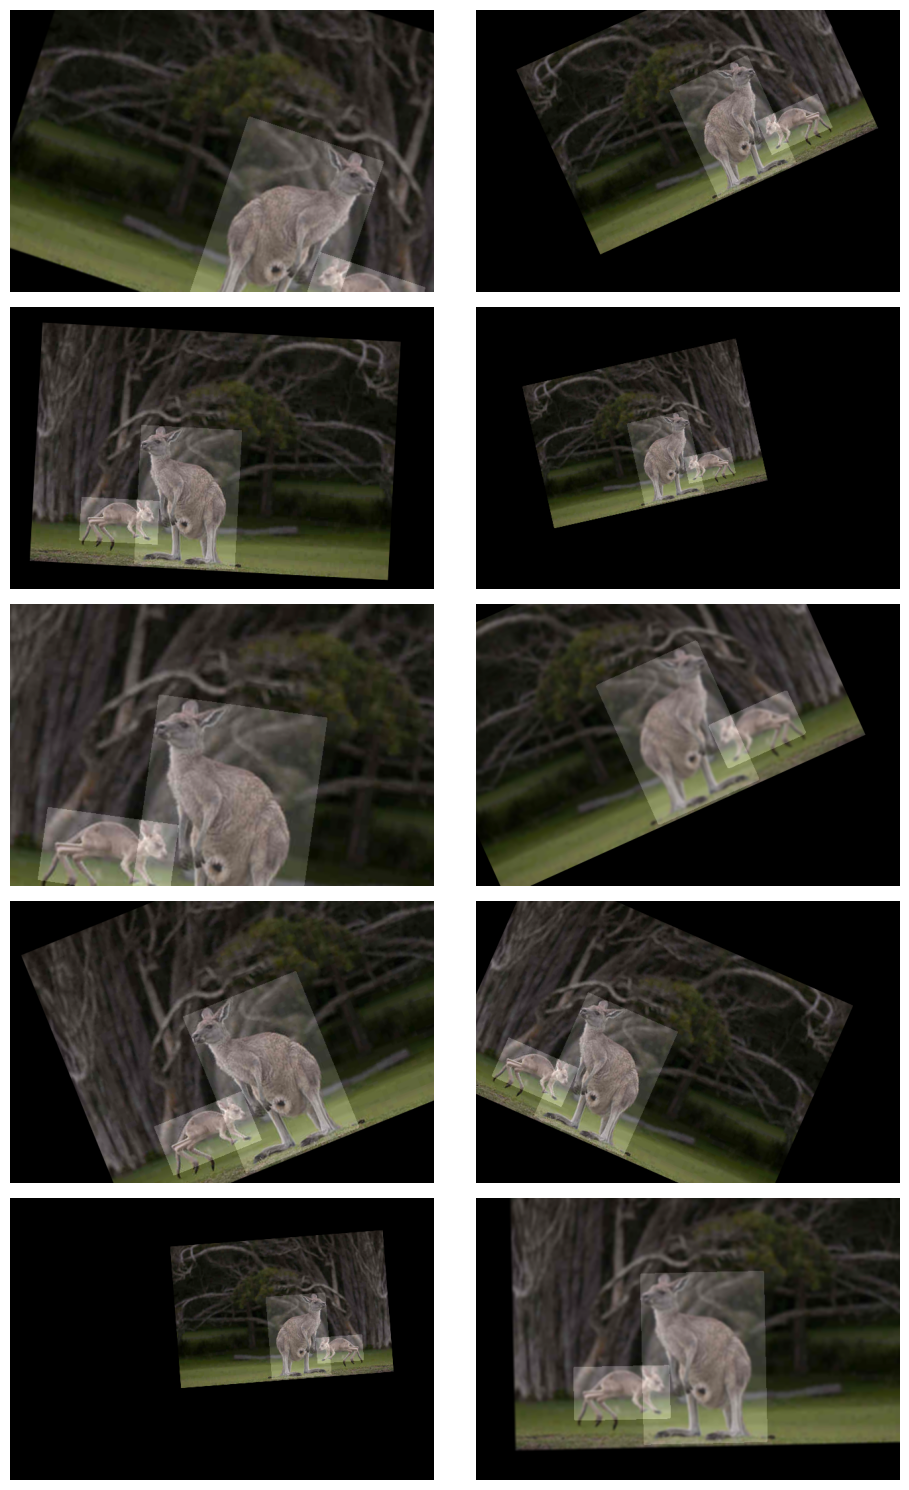

In [11]:
img_row_size = 3
img_col_size = 5
fig_size = (n_cols * img_col_size, n_rows * img_row_size)
fig, axs = plt.subplots(
	ncols=n_cols, nrows=n_rows, 
	figsize=fig_size,
	sharex=True, sharey=True,
)
print(fig_size)
for index, (aug_image, aug_mask) in enumerate(augmentations):
	i, j = index // n_cols, index % n_cols 
	ax = axs[i, j]
	ax.axis('off')
	ax.imshow(aug_image)
	for mask_idx in range(aug_mask.shape[2]):
		ax.imshow(aug_mask[:,:, mask_idx], cmap='gray', alpha=0.2)
plt.tight_layout()
plt.show()